# Abstract: Sentiment Analysis
In this notebook, we will be addressing a **binary classification problem**. Our goal is to predict whether a tweet is classified as positive or negative. This is a supervised learning task. To accomplish this, we will conduct extensive preprocessing, which is typical for natural language processing (NLP) problems. Afterward, we will train a multilayer neural network using the training dataset. Finally, we will evaluate the performance of our model on the test set.

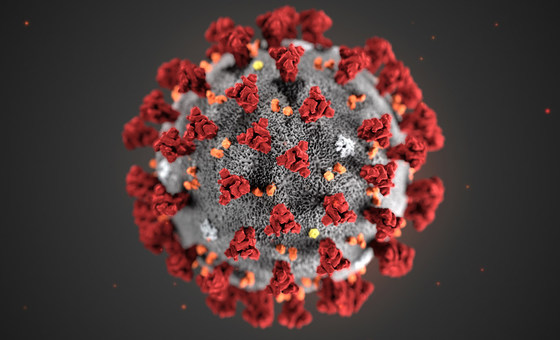

### Importing libararies

We need to import libraries and also download stopwords from `nltk`.

In [1]:
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1-Reading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Train dataset
train_set = pd.read_csv("/content/drive/MyDrive/Python/Datasets/Text Classification with ANN/Corona_NLP_train.csv",encoding="latin-1")
train_set_Copy = train_set.copy()

#test dataset
test_set=pd.read_csv('/content/drive/MyDrive/Python/Datasets/Text Classification with ANN/Corona_NLP_test.csv')
test_set_Copy = train_set.copy()

# 2-EDA

In [4]:
train_set.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
test_set.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


**Info:**
* By looking at the columns, it seems evident that the `Location` column needs to be **standardized**.
* However, if we don't use the `Location` column in our study, there would be no need to alter it.

In [6]:
print("    Train dataset info: \n")
train_set.info()

print("---------------------------\n\n    Test dataset info: \n")
test_set.info()

    Train dataset info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
---------------------------

    Test dataset info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentim

**Info:**
* There are some null values in the `Location` column, while others do not contain any null values.
* Additionally, we may need to modify some format types, such as time (the `TweetAt` column).

**There are some decisions to be made:**

1. Which variables do we want to use?
2. How do we handle null values in the *Location* column?
3. How do we deal with the *sentiment* classes?
-------------------------------------------------------------------------------------------------------------------------------------

For this project, we have decided to focus solely on the content of the tweets, turning this into a pure NLP problem. Although it is possible to incorporate other columns and potentially achieve better results, we have intentionally omitted them. For instance, there may be certain cities or locations with a higher proportion of positive tweets, which could be informative.

**So the answers to the questions are as follows:**

1. We will only utilize the *OriginalTweet* column, which contains the tweets.
2. This question is not relevant because we will not be using the *Location* column.
3. We will convert the five sentiment classes into two categories: positive and negative.

## Duplicates


In [7]:
# count the number of duplicate rows
num_duplicates = train_set.duplicated().sum()

print(f"There are {num_duplicates} duplicate rows in the DataFrame.")

There are 0 duplicate rows in the DataFrame.


## Filtering

The independent attributes that convey information are:

1. *Location*
2. Time (*TweetedAt*)
3. Text (*OriginalTweet*)

It should be noted that although we will not be using the *TweetedAt* and *Location* columns in our analysis, we will still conduct a minor exploratory data analysis (EDA) on these columns.

In [8]:
train_set = train_set.loc[:, ['Location', 'TweetAt', 'OriginalTweet','Sentiment']]
train_set.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


**Info:**
* It is evident that the `OriginalTweet` column will contain different values since each tweet is unique - it is unlikely that multiple people would copy the exact same tweet. Therefore, the *OriginalTweet* column will require preprocessing before analysis. However, we will not be analyzing this column in this particular section. Instead, we will focus on analyzing the *Location*, *TweetAt*, and *Sentiment* columns to determine the different values and frequencies.

### Location

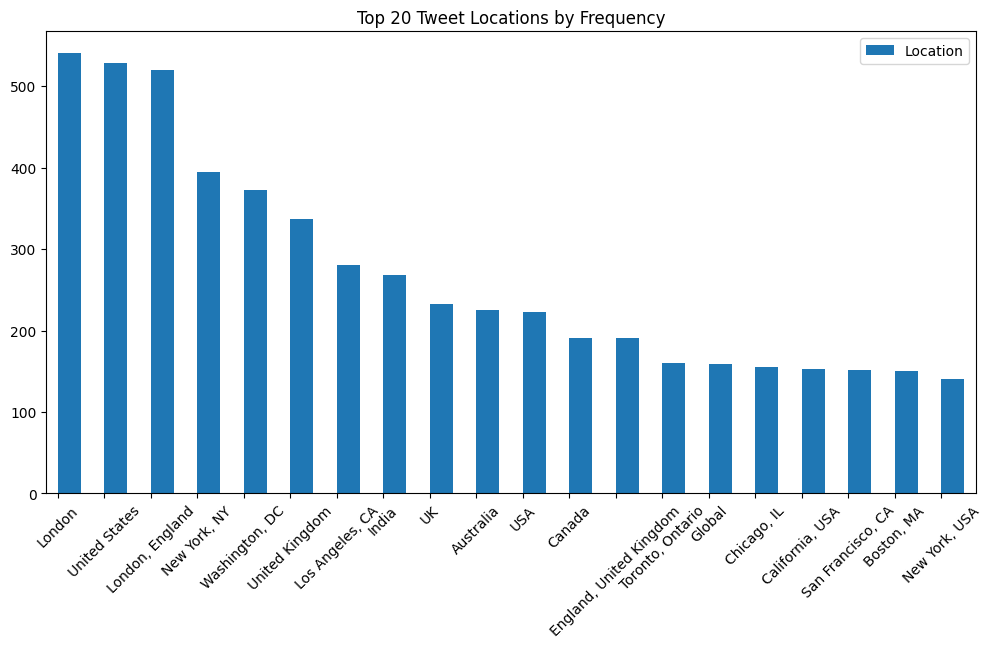

In [9]:
# Find unique values and their frequencies in the Location column
unique_value_counts = pd.DataFrame({
    'Location': train_set['Location'].value_counts()})

# Sort by descending frequency
unique_value_counts = unique_value_counts.sort_values(by=['Location'], ascending=False)

# Create bar chart of top 20 frequent values in the Location column
top_20 = unique_value_counts.head(20)
top_20.plot.bar(rot=45, figsize=(12, 6), align='edge')  # Rotate x-axis labels by 45 degrees
plt.title("Top 20 Tweet Locations by Frequency")
plt.show()

**Info:**
* As you can see, the `Location` data is quite messy and will require significant cleaning.
* Additionally, it is worth noting that the bar with no caption represents tweets that do not specify a location.

### Sentiment

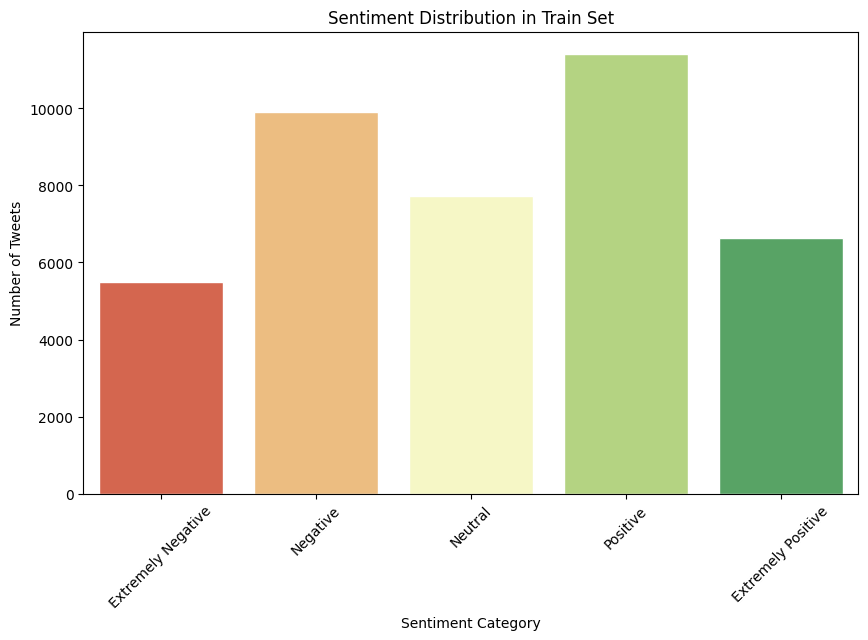

In [10]:
# define the order of the sentiment categories
sentiment_order = ["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]

# create a color palette from red to green
colors = sns.color_palette("RdYlGn", len(sentiment_order))

# set the color map for the barplot
color_map = dict(zip(sentiment_order, colors))

# count the number of instances for each sentiment category
sentiment_counts = train_set["Sentiment"].value_counts()

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# create a bar plot using seaborn with the desired order and color map
sns.set(style="darkgrid")
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=sentiment_order, ax=ax, palette=color_map)

# set plot title and axis labels
ax.set_title("Sentiment Distribution in Train Set")
ax.set_xlabel("Sentiment Category")
ax.set_ylabel("Number of Tweets")

# rotate x-axis labels
ax.tick_params(axis='x', rotation=45)

plt.show()

**Info:**
* The number of classes to use depends on the model. For this particular project, we have decided to convert the problem into a binary classification task.
* To achieve this, we have defined some functions to convert the training set and later the test set into an appropriate format for binary classification. Additionally, we will only be using the tweets for the classification task and will discard all other information for now.

It is worth noting that to convert the five classes into two, we will drop the *Neutral* class and combine the other two classes into one class each.

In [11]:
def choosingcol(df):
    new_df=df.loc[:, ['OriginalTweet', 'Sentiment']]
    return new_df

#------------------------------------------------------------------
def reducing_sentiment(df):
    df = df.loc[df['Sentiment'] != 'Neutral']

    # replace extremely positive and extremely negative with positive and negative, respectively
    df['Sentiment'] = df['Sentiment'].replace({'Extremely Positive': 'Positive', 'Extremely Negative': 'Negative'})

    return df
#-----------------------------------------------------------------
def converting_tonumeric(df):
    sentiment_dict = {'Positive': 1, 'Negative': 0}
    df['Sentiment'] = df['Sentiment'].replace(sentiment_dict)
    return df

In [12]:
# Using functions to make train_set ready
train_set = choosingcol(train_set)
train_set = reducing_sentiment(train_set)
train_set = converting_tonumeric(train_set)
train_set = train_set.reset_index(drop=True)
train_set

<ipython-input-11-a831c1d27b95>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].replace({'Extremely Positive': 'Positive', 'Extremely Negative': 'Negative'})


,OriginalTweet,Sentiment
0,advice Talk to your neighbours family to excha...,1
1,Coronavirus Australia: Woolworths to give elde...,1
2,My food stock is not the only one which is emp...,1
3,"Me, ready to go at supermarket during the #COV...",0
4,As news of the regionÂs first confirmed COVID...,1
...,...,...
33439,I never that weÂd be in a situation &amp; wor...,1
33440,@MrSilverScott you are definitely my man. I fe...,1
33441,Response to complaint not provided citing COVI...,0
33442,You know itÂs getting tough when @KameronWild...,1


**Info:**
* Before applying the functions, we had 41,157 tweets. After applying the functions to convert the problem into a binary classification task, **we were left with 33,444 tweets**, which is a sufficient amount for the learning task. We have also created a pie chart to better visualize the two classes.

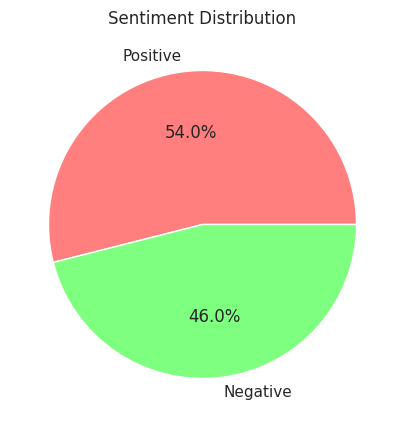

In [13]:
# Count the number of occurrences of each sentiment value
sentiment_counts = train_set["Sentiment"].value_counts()

# Create a pie chart
labels = [ 'Positive','Negative']
colors = [(1, 0, 0, 0.5), (0, 1, 0, 0.5)]

plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=labels, colors=colors, autopct='%1.1f%%')

plt.title('Sentiment Distribution')
plt.show()

# 3-NLP preprocessing

First, we define some functions that will be used for preprocessing the text. Typically, text preprocessing involves **removing irregular expressions**, **Expanding contractions**, **tokenizing**, **removing punctuation and stopwords**, and **stemming**. Since the training and test datasets are separate, using functions makes our work easier and more efficient.

The *contractions_dict* was generated via prompt in ChatGPT. We will be using this dictionary in the `expanding_words` function.

In [14]:
contractions_dict = {
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'll": "he shall / he will",
    "he's": "he is",
    "I'd": "I had / I would",
    "I'll": "I shall / I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'll": "it shall / it will",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she had / she would",
    "she'll": "she shall / she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they had / they would",
    "they'll": "they shall / they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'll": "we shall / we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where's": "where is",
    "who'd": "who had / who would",
    "who'll": "who shall / who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you had / you would",
    "you'll": "you shall / you will",
    "you're": "you are",
    "you've": "you have"
}

**Info:**
* It is important to note that the removal of punctuation and stopwords is carried out in the `tokenizing` function, along with tokenizing the text.

In [15]:
def cleaning_with_re(tweet):
    tweet = re.sub(r'^RT[\s]+', '', tweet)

    # remove hyperlinks
    tweet = re.sub(r'https?://(?:www\.[^\s\n\r]+|[^\s\n\r]+)', '', tweet)

    # remove hashtag (#)
    tweet = re.sub(r'#', '', tweet)

    #replaces newline (\n) and carriage return (\r) characters in a tweet with an empty string
    tweet = re.sub(r'[\n\r]', '', tweet)

    #replaces the numbers with an empty string
    tweet = re.sub(r'\d+', '', tweet)

    return tweet

#----------------------------------------------------------------
def expanding_words(tweet):

    words = tweet.split()
    expanded_words = []
    for word in words:
        if word.lower() in contractions_dict:
            expanded_words.extend(contractions_dict[word.lower()].split("/"))
        else:
            expanded_words.append(word)
    return " ".join(expanded_words)

#----------------------------------------------------------------
def tokenizing(tweet):

    stopwords_english = stopwords.words('english')
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    new_tweet = tokenizer.tokenize(tweet)

    clean_tweet=[]

    for word in new_tweet: # Going through every word in tokens list
        if (word not in stopwords_english and word not in string.punctuation):  # remove punctuation and stopwords
            clean_tweet.append(word)

    return clean_tweet

#----------------------------------------------------------------
def stemming(tweet):
    # Instantiate stemming class
    stemmer = PorterStemmer()

    # Create an empty list to store the stems
    stemmed_tweets = []

    for word in tweet:
        stem_word = stemmer.stem(word)  # stemming word
        stemmed_tweets.append(stem_word)  # append to the list

    return stemmed_tweets

We aimed to write understandable code, even if it meant writing slightly longer code, as our target audience are beginners. As a result, we have combined all the preprocessing functions into a single function that can be applied to any dataset.

In [16]:
def preprocessing(tweet):

    tweet=cleaning_with_re(tweet)
    tweet=expanding_words(tweet)
    tweet=tokenizing(tweet)
    tweet=stemming(tweet)

    return tweet

## Text representation (feature extraction)

Below, we have written two additional functions for feature extraction. The main objective of these functions is to address the text representation problem. The first function enumerates the frequency of each word in both classes and outputs a dictionary. The second function takes a tweet and creates two features that show the sum frequencies of the tweet's words in the positive and negative classes.

In [17]:
def build_freqs(listoftweets, labels):

    labelslist = np.squeeze(labels).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets and all the words in them
    freqs = {}
    for y, tweet in zip(labels, listoftweets):
        t=preprocessing(tweet)
        for word in t:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    # Calculate the sum of frequencies for each word
    word_sums = {}
    for (word, y), count in freqs.items():
        if word in word_sums:
            word_sums[word] += count
        else:
            word_sums[word] = count

    # Divide each key of word and class by the sum
    for (word, y), count in freqs.items():
        freqs[(word, y)] /= word_sums[word]

    return freqs

#------------------------------------------------------------------
def extract_features(tweet, freqs, preprocessing=preprocessing):

    # process_tweet tokenizes, stems, and removes stopwords
    word_list = preprocessing(tweet)

    # 2 elements for [ positive, negative] counts
    features = np.zeros(2)

    # loop through each word in the list of words
    for word in word_list:

        # increment the word count for the positive label 1
        features[0] += freqs.get((word, 1.0),0)

        # increment the word count for the negative label 0
        features[1] += freqs.get((word, 0),0)

    features = features[None, :]
    assert(features.shape == (1, 2))
    return features

In [18]:
%%time
word_frequencies=build_freqs(train_set['OriginalTweet'].tolist(), train_set['Sentiment'].tolist())

CPU times: user 39.4 s, sys: 855 ms, total: 40.3 s
Wall time: 40.6 s


## Specifying X and Y for learning process

In [19]:
X = np.zeros((len(train_set['Sentiment']), 2))
for i in range(len(train_set['Sentiment'])):
    X[i, :]= extract_features(train_set['OriginalTweet'][i], word_frequencies)

print(X)

# training labels corresponding to X
Y = np.array(train_set['Sentiment'])

[[16.3560229  10.6439771 ]
 [ 6.76148304  5.23851696]
 [12.58309543  9.41690457]
 ...
 [ 6.18436737  8.81563263]
 [ 7.60920151  5.39079849]
 [12.35803669 13.64196331]]


# 4-Training
For this task, we will be using a sequential neural network model. The training process is shown below. We will use binary cross-entropy loss and Adam optimizer with a learning rate of 0.001. We will train the model for 70 epochs with a batch size of 32.

In [20]:
# Model
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))  # Hidden layer with 4 neurons
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Output layer with logistic regression

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(X, Y, epochs=60, batch_size=32)

Epoch 1/60
1046/1046 [==============================] - 4s 3ms/step - loss: 1.8396 - accuracy: 0.4256
Epoch 2/60
1046/1046 [==============================] - 3s 3ms/step - loss: 0.7214 - accuracy: 0.4771
Epoch 3/60
1046/1046 [==============================] - 2s 2ms/step - loss: 0.6893 - accuracy: 0.5386
Epoch 4/60
1046/1046 [==============================] - 2s 2ms/step - loss: 0.6311 - accuracy: 0.6147
Epoch 5/60
1046/1046 [==============================] - 2s 2ms/step - loss: 0.5169 - accuracy: 0.7739
Epoch 6/60
1046/1046 [==============================] - 2s 2ms/step - loss: 0.4583 - accuracy: 0.7995
Epoch 7/60
1046/1046 [==============================] - 2s 2ms/step - loss: 0.4354 - accuracy: 0.8078
Epoch 8/60
1046/1046 [==============================] - 3s 3ms/step - loss: 0.4278 - accuracy: 0.8106
Epoch 9/60
1046/1046 [==============================] - 2s 2ms/step - loss: 0.4281 - accuracy: 0.8090
Epoch 10/60
1046/1046 [==============================] - 2s 2ms/step - loss: 0.425

# 5-Evaluation
In this section, we will apply the preprocessing functions to the test dataset and evaluate the performance of the trained model on the test set using various evaluation metrics.

In [21]:
test_set=choosingcol(test_set)
test_set=reducing_sentiment(test_set)
test_set=converting_tonumeric(test_set)
test_set=test_set.reset_index(drop=True)
test_set

<ipython-input-11-a831c1d27b95>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].replace({'Extremely Positive': 'Positive', 'Extremely Negative': 'Negative'})


,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,0
1,When I couldn't find hand sanitizer at Fred Me...,1
2,Find out how you can protect yourself and love...,1
3,#Panic buying hits #NewYork City as anxious sh...,0
4,Voting in the age of #coronavirus = hand sanit...,1
...,...,...
3174,"@RicePolitics @MDCounties Craig, will you call...",0
3175,Meanwhile In A Supermarket in Israel -- People...,1
3176,Did you panic buy a lot of non-perishable item...,0
3177,Gov need to do somethings instead of biar je r...,0


In [22]:
X_test = np.zeros((len(test_set['Sentiment']), 2))
for i in range(len(test_set['Sentiment'])):
    X_test[i, :]= extract_features(test_set['OriginalTweet'][i], word_frequencies)
print(X_test)

[[ 6.99719209  7.00280791]
 [ 9.49902514  5.50097486]
 [ 3.19186408  1.80813592]
 ...
 [10.34801656  7.65198344]
 [ 7.32688164  9.67311836]
 [ 9.09976746  4.90023254]]


In [23]:
y_prob = model.predict(X_test)
y_pred = np.round(y_prob).flatten()
y_test = test_set['Sentiment'].tolist()

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test set accuracy = {accuracy}")
print(f"Test set precision = {precision}")
print(f"Test set recall = {recall}")
print(f"Test set F1 score = {f1}")

100/100 [==============================] - 0s 2ms/step
Test set accuracy = 0.75243787354514
Test set precision = 0.7472312703583062
Test set recall = 0.7419146183699871
Test set F1 score = 0.7445634534242128


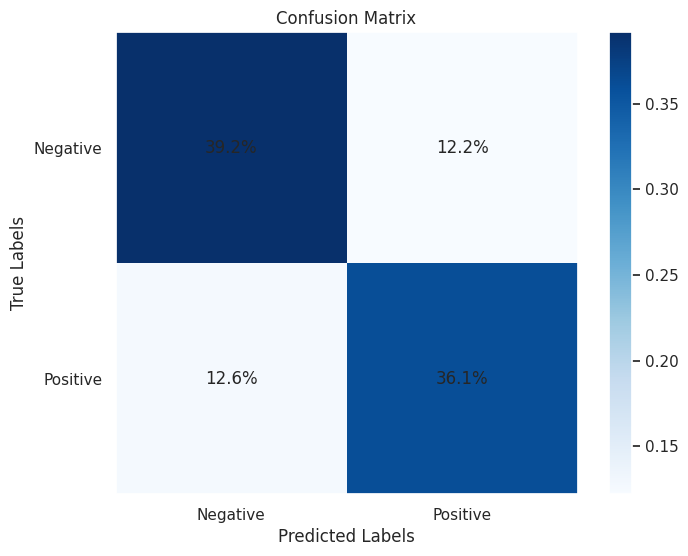

In [24]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_norm = cm / np.sum(cm)

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the heatmap
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()

# Display the percentages in the plot
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, '{:.1%}'.format(cm_norm[i, j]), ha='center', va='center')

# Remove the grid lines
plt.grid(False)
plt.title('Confusion Matrix')
plt.show()

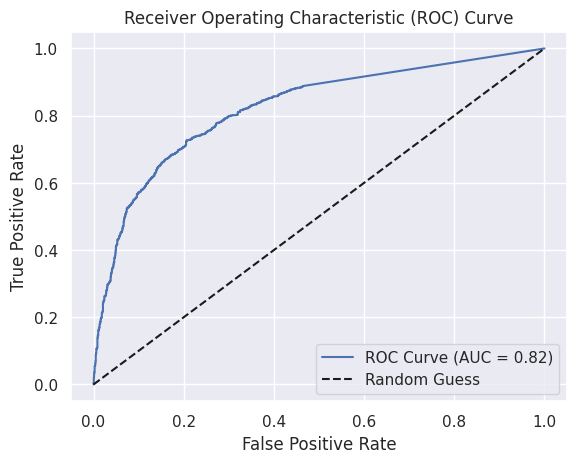

In [25]:
# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Conclusion
<font size="4">The results look good, but they could potentially be improved by performing better and more complex feature engineering during the text representation phase. Additionally, testing other models could help determine which model performs the best.
This method of feature engineering has been tested on the built-in datasets in the NLTK library, and the results were much better. However, considering the context, we don't expect to achieve significantly better results with this method.

<font size="4">It is worth noting that some of the code in the preprocessing section was inspired by the fantastic course [Natural Language Processing](https://www.coursera.org/specializations/natural-language-processing) from Coursera.

<font size="4">We would be happy to receive any suggestions and are available to provide further explanation if needed. Please feel free to start a discussion.

<font size="5">Thank you for your attention, and if you found our work helpful, please consider upvoting.
